<a href="https://colab.research.google.com/github/flora0110/podcast_segment_headine/blob/main/podcast_to_headline_del_spon_history_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textsplit

In [170]:
!pip install word2vec

In [171]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [172]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

In [173]:
links = {'podcast_text': 'https://raw.githubusercontent.com/grace-boop/podcast/main/flora_darkhistory'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

## Train wordvectors

In [174]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)

In [175]:
model.save(wrdvec_path)

In [176]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)

## get sentence tokenizer

In [177]:
!pip install textsplit

In [178]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [179]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

### podcast

In [180]:
#@title segment target length in sentences { display-mode: "form" }
segment_len =  25#@param {type:"integer"}

25.13961017995307
penalty 42.09
632 sentences, 32 segments, avg 19.75 sentences per segment
optimal score 14868.87, greedy score 14821.02
[14868.867870187556, 14821.01655275774]
(14868.867870187556, 14821.01655275774)
ratio of scores 1.0032


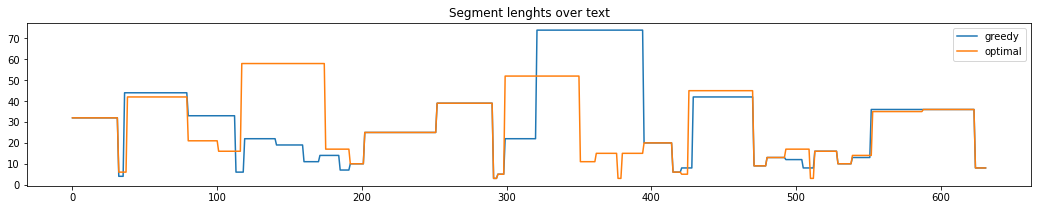

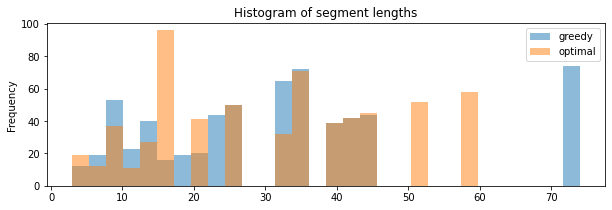

In [181]:
link = links['podcast_text']
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
strs = " "
for i in range(len(sentenced_text)):
  if(sentenced_text[i] != " "):
    strs =sentenced_text[i]
  if(i+1<len(sentenced_text)):
    if(strs == sentenced_text[i+1]):
      sentenced_text[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)
new_length = len(sentenced_text)**0.5
print(new_length)
penalty = get_penalty([sentence_vectors], new_length)
#penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

#### 顯示分段

In [182]:
for i in range(len(segmented_text)):
  print(segmented_text[i])
  

['Hi friends. ', "Happy Wednesday or Thursday if you're watching over on YouTube. ", 'Hey, how are you doing? ', "I hope you're having a wonderful day so far. ", 'My name is Bailey. ', 'Sarian. ', 'And this is the dark History podcast on your team song for dark history. ', "Don't I anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that I never learned in school if you're new here. ", 'Hi, welcome, take a seat by me. ', "Don't be shy. ", "If you're interested in learning about people and events that your history books in a covering school and maybe should have then you'll fit in right in here with us. ", 'Ok luck today, story. ', "It's uncomfortable. ", "Okay, it's heartbreaking. ", "It's it's just, it's it's awful. ", "It's that there's, those are all the words I can think of it, just doesn't make any sense. ", "But with all of that being said, there's really like, no sugar-coating this, this is what happened and it's when we

In [183]:
first_sentence = []
for i in range(len(segmented_text)):
  first_sentence.append(segmented_text[i][0].strip().rstrip().rstrip('.'))
  print(segmented_text[i][0])
  print(type(segmented_text[i][0]))
  print(len(segmented_text[i]))
print(first_sentence)
1

Hi friends. 
<class 'str'>
32
For all of that, on the morning of January 1st, 1923 30 year old James, and his 22-year old wife, Fannie, Taylor woke up at a home, and a town called Sumner, a neighboring community of Rosewood. 
<class 'str'>
6
I know because it is. 
<class 'str'>
42
Now, it's a Rosewood. 
<class 'str'>
21
But again, for your brain, not only that, best fiends is so funny, won't want to put it down. 
<class 'str'>
16
Today's episode January, 1st. 
<class 'str'>
58
Saw black man attacks. 
<class 'str'>
17
Why, why would she lie, why would you lie? 
<class 'str'>
10
Zero evidence that Jesse was the perpetrator, but that doesn't matter to them. 
<class 'str'>
25
So they know exactly where Sam Carter lives and they had straight to his house. 
<class 'str'>
25
This is just the tip of the iceberg. 
<class 'str'>
39
So the black community is terrified by what they're seeing happening in their own town of Rosewood. 
<class 'str'>
3
Other than Sarah carriers house. 
<class 'str'>
5

1

In [184]:
print(sentenced_text)

['Hi friends. ', "Happy Wednesday or Thursday if you're watching over on YouTube. ", 'Hey, how are you doing? ', "I hope you're having a wonderful day so far. ", 'My name is Bailey. ', 'Sarian. ', 'And this is the dark History podcast on your team song for dark history. ', "Don't I anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that I never learned in school if you're new here. ", 'Hi, welcome, take a seat by me. ', "Don't be shy. ", "If you're interested in learning about people and events that your history books in a covering school and maybe should have then you'll fit in right in here with us. ", 'Ok luck today, story. ', "It's uncomfortable. ", "Okay, it's heartbreaking. ", "It's it's just, it's it's awful. ", "It's that there's, those are all the words I can think of it, just doesn't make any sense. ", "But with all of that being said, there's really like, no sugar-coating this, this is what happened and it's when we

### 處理輸入

In [185]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [186]:
print(podcast_test)

["Hi friends. Happy Wednesday or Thursday if you're watching over on YouTube. Hey, how are you doing? I hope you're having a wonderful day so far. My name is Bailey. Sarian. And this is the dark History podcast on your team song for dark history. Don't I anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that I never learned in school if you're new here. Hi, welcome, take a seat by me. Don't be shy. If you're interested in learning about people and events that your history books in a covering school and maybe should have then you'll fit in right in here with us. Ok luck today, story. It's uncomfortable. Okay, it's heartbreaking. It's it's just, it's it's awful. It's that there's, those are all the words I can think of it, just doesn't make any sense. But with all of that being said, there's really like, no sugar-coating this, this is what happened and it's when were honest and when were transparent that we can learn and grow t

# Headline generator

In [187]:
! pip install transformers datasets

In [188]:
!pip install sentencepiece

In [189]:
from transformers import pipeline

## 使用Michau/t5-base-en-generate-headline

In [190]:
headlineGenerator = pipeline(model="Michau/t5-base-en-generate-headline", tokenizer="Michau/t5-base-en-generate-headline")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

In [191]:
#@title 生成標題的長度 { display-mode: "form" }
min_length =  5#@param {type:"integer"}
max_length = 150#@param {type:"integer"}

In [192]:
headlines = headlineGenerator(podcast_test, min_length, max_length)


Ignoring args : (5, 150)
Token indices sequence length is longer than the specified maximum sequence length for this model (610 > 512). Running this sequence through the model will result in indexing errors


### 顯示結果

In [193]:
for headline in headlines:
  print(headline)
  print(type(headline))

{'generated_text': 'Dark History Podcast - A Dark History Podcast'}
<class 'dict'>
{'generated_text': 'Rosewood, Florida - A Story of a Hero'}
<class 'dict'>
{'generated_text': 'The Rosewood Massacre'}
<class 'dict'>
{'generated_text': 'The Best Fiends - The Mobile Puzzle Game'}
<class 'dict'>
{'generated_text': 'Best Fiends Puzzle Game Review'}
<class 'dict'>
{'generated_text': 'The Story of Saint Nick'}
<class 'dict'>
{'generated_text': 'Annie, Let It Go!'}
<class 'dict'>
{'generated_text': 'Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter'}
<class 'dict'>
{'generated_text': 'Jesse Hunter, a Black Man, Attack Force Panty'}
<class 'dict'>
{'generated_text': 'Sam Carter, The Posse Stop Process'}
<class 'dict'>
{'generated_text': 'Hello Fresh - The Best Meal Kits For the Dark History Posse'}
<class 'dict'>
{'generated_text': 'Rosewood Black Community - Is Jesse hiding in a Home?'}
<class 'dict'>
{'generated_text': 'Sarah Carriers House'}
<class 'dict'>
{'generated_te

In [194]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['Dark History Podcast', '-', 'A Dark History Podcast']
['Dark History Podcast', '-', 'A Dark History Podcast']
<class 'str'>
['Rosewood', ',', 'Florida', '-', 'A Story of a Hero']
['Rosewood', ',', 'Florida', '-', 'A Story of a Hero']
<class 'str'>
['The Rosewood Massacre']
['The Rosewood Massacre']
<class 'str'>
['The Best Fiends', '-', 'The Mobile Puzzle Game']
['The Best Fiends', '-', 'The Mobile Puzzle Game']
<class 'str'>
['Best Fiends Puzzle Game Review']
['Best Fiends Puzzle Game Review']
<class 'str'>
['The Story of Saint Nick']
['The Story of Saint Nick']
<class 'str'>
['Annie', ',', 'Let It Go!']
['Annie', ',', 'Let It Go!']
<class 'str'>
['Jesse Hunter', ',', 'Jesse Hunter', ',', 'Jesse Hunter', ',', 'Jesse Hunter', ',', 'Jesse Hunter']
['Jesse Hunter', ',', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
<class 'str'>
['Jesse Hunter', ',', 'a Black Man', ',', 'Attack Force Panty']
['Jesse Hunter', ',', 'a Black Man', ' ', 'Attack Force Panty']
<class 'str'>
['Sam Carter', ',', 'The Pos

In [195]:
for headline_string in headlines_string:
  print(headline_string)

 Dark History Podcast - A Dark History Podcast
 Rosewood , Florida - A Story of a Hero
 The Rosewood Massacre
 The Best Fiends - The Mobile Puzzle Game
 Best Fiends Puzzle Game Review
 The Story of Saint Nick
 Annie , Let It Go!
 Jesse Hunter ,
 Jesse Hunter , a Black Man Attack Force Panty
 Sam Carter , The Posse Stop Process
 Hello Fresh - The Best Meal Kits For the Dark History Posse
 Rosewood Black Community - Is Jesse hiding in a Home?
 Sarah Carriers House
 The Posse and the White Mob
 The Black Community in Rosewood
 The White Man , But He Was Friendly to His Neighborhoods
 Rosewood Massacre - The Rosewood Massacre
 The KKK , The 'Klaus'
 The Mob Shot Mingo Williams
 What's a lot of names and Throwing at you?
 The Rosewood Train Station
 Squarespace - The Perfect Platform For Your Brand
 The Rosewood Massacre - The All White Jury
 The Little Things in Life Are Smiling At Your Neighbor
 Save Money With Stamps . com
 Rosewood , the survivors are living in constant fear
 The Black 

In [196]:
print(headlines_string)

[' Dark History Podcast - A Dark History Podcast', ' Rosewood , Florida - A Story of a Hero', ' The Rosewood Massacre', ' The Best Fiends - The Mobile Puzzle Game', ' Best Fiends Puzzle Game Review', ' The Story of Saint Nick', ' Annie , Let It Go!', ' Jesse Hunter ,', ' Jesse Hunter , a Black Man Attack Force Panty', ' Sam Carter , The Posse Stop Process', ' Hello Fresh - The Best Meal Kits For the Dark History Posse', ' Rosewood Black Community - Is Jesse hiding in a Home?', ' Sarah Carriers House', ' The Posse and the White Mob', ' The Black Community in Rosewood', ' The White Man , But He Was Friendly to His Neighborhoods', ' Rosewood Massacre - The Rosewood Massacre', " The KKK , The 'Klaus'", ' The Mob Shot Mingo Williams', " What's a lot of names and Throwing at you?", ' The Rosewood Train Station', ' Squarespace - The Perfect Platform For Your Brand', ' The Rosewood Massacre - The All White Jury', ' The Little Things in Life Are Smiling At Your Neighbor', ' Save Money With Stam

In [197]:
b = "abc, ss dd, www"
a = re.split(r"([,])",b)
print(a)

['abc', ',', ' ss dd', ',', ' www']


# 去掉廣告

In [198]:
!pip install -U scikit-learn
!pip install --user -U nltk

In [199]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## 使用停使用停用詞(NLTK)

In [200]:
# 下面的代碼是使用nltk從句子中去除停用詞 
# 導入包 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download("stopwords")
#set(stopwords.words('english')) 
# 例句 
#text = """He determined to drop his litigation with the monastry, and relinguish his claims to the wood-cuting and fishery rihgts at once. He was the more ready to do this becuase the rights had become much less valuable, and he had indeed the vaguest idea where the wood and river in question were.""" 
# 停用詞集合 
stop_words = set(stopwords.words('english')) 
# 分詞 
nltk.download('punkt')
result_nltk = []
for sent in podcast_test:
  word_tokens = word_tokenize(sent) 
  filtered_sentence = [] 
  for w in word_tokens: 
    if w not in stop_words: 
      filtered_sentence.append(w) 
  result_nltk.append(" ".join(filtered_sentence))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [201]:
print(len(result_nltk))
print(result_nltk)

32
["Hi friends . Happy Wednesday Thursday 're watching YouTube . Hey , ? I hope 're wonderful day far . My name Bailey . Sarian . And dark History podcast team song dark history . Do n't I anywho , I 'm talk dark ass history never learned school I , least say I never learned school 're new . Hi , welcome , take seat . Do n't shy . If 're interested learning people events history books covering school maybe 'll fit right us . Ok luck today , story . It 's uncomfortable . Okay , 's heartbreaking . It 's 's , 's 's awful . It 's 's , words I think , n't make sense . But said , 's really like , sugar-coating , happened 's honest transparent learn grow together , know , But let history repeat . So let 's set scene . It 's New Year 's Day , 1923 many people waking celebrating New Year . Some still wearing flapper dress suit tired dancing . The night away jazz club , maybe 're hung buying illegal drinks speakeasy . Yes . Oh , yes . It still illegal buy alcohol wild , right ? Of course , thou

In [202]:
vectorizer_nltk = CountVectorizer()
transformer_nltk = TfidfTransformer()
tfidf_nltk = transformer_nltk.fit_transform(vectorizer_nltk.fit_transform(result_nltk))
feature_name_nltk = vectorizer_nltk.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [203]:
print(len(feature_name_nltk))
print(feature_name_nltk)

1462
['10', '100', '14', '16', '1800s', '1870s', '1886', '1890', '1903', '1920s', '1921', '1923', '1931', '1st', '20', '200', '2020', '22', '24', '30', '300', '45', '4th', '50', '5th', '6th', '71', 'ability', 'able', 'absolutely', 'acceptable', 'according', 'accused', 'acknowledged', 'across', 'action', 'actually', 'addition', 'adorable', 'adrenaline', 'affair', 'affordable', 'afraid', 'after', 'again', 'aggressive', 'ago', 'agree', 'ahead', 'airs', 'aka', 'alabama', 'alcohol', 'alert', 'alive', 'all', 'alleged', 'allegedly', 'alley', 'allow', 'allowed', 'allowing', 'almost', 'alone', 'along', 'also', 'although', 'always', 'amazing', 'america', 'amongst', 'amount', 'and', 'andrews', 'andros', 'anger', 'angry', 'annie', 'another', 'answer', 'answers', 'anthropology', 'any', 'anyone', 'anything', 'anytime', 'anyting', 'anyways', 'anywhere', 'anywho', 'app', 'appealing', 'appreciate', 'are', 'area', 'areas', 'ariel', 'armed', 'arnett', 'around', 'arrested', 'as', 'aside', 'ask', 'asked', 

In [204]:
sponsor_n =0
for i in range(len(feature_name_nltk)):
  if feature_name_nltk[i]=='sponsor':
    sponsor_n =i
    print(i)

1193


In [205]:
# 找出含sponsor的段落內的keyword和其tfidf
from nltk.util import pr
print(type(tfidf_nltk))
keyword_segment = []
tfidf_segment = []
#print(tfidf_nltk)
#print(tfidf_nltk.toarray())
array_tfidf_nltk = tfidf_nltk.toarray()
#print(array_tfidf_nltk)
#print(array_tfidf_nltk[0])
for i in range(len(array_tfidf_nltk)):
  if(array_tfidf_nltk[i][sponsor_n]>0):
    print(i)
    for j in range(len(array_tfidf_nltk[i])):
      if(array_tfidf_nltk[i][j]>0):
        keyword_segment.append(feature_name_nltk[j])
        tfidf_segment.append(array_tfidf_nltk[i][j])
        print(feature_name_nltk[j]," ",array_tfidf_nltk[i][j])

<class 'scipy.sparse.csr.csr_matrix'>
3
20   0.08576608638645224
addition   0.09600040872330802
almost   0.09600040872330802
also   0.05297095654550501
andros   0.09600040872330802
another   0.1220180590698746
anyone   0.08576608638645224
ask   0.08576608638645224
back   0.04514235317828478
baseball   0.09600040872330802
become   0.07850471912912266
best   0.14574473021865184
brain   0.17153217277290447
bruin   0.19200081744661604
but   0.09376759685255948
challenge   0.09600040872330802
churches   0.08576608638645224
close   0.08576608638645224
coexisted   0.09600040872330802
communities   0.07850471912912266
community   0.04351333994075194
cuz   0.08576608638645224
end   0.07850471912912266
even   0.04351333994075194
everyone   0.08576608638645224
everything   0.07287236510932592
exercise   0.09600040872330802
feels   0.08576608638645224
felt   0.09600040872330802
fiends   0.17153217277290447
food   0.09600040872330802
fun   0.07287236510932592
game   0.08576608638645224
general   0.

In [206]:
print(keyword_segment)
print(tfidf_segment)

['20', 'addition', 'almost', 'also', 'andros', 'another', 'anyone', 'ask', 'back', 'baseball', 'become', 'best', 'brain', 'bruin', 'but', 'challenge', 'churches', 'close', 'coexisted', 'communities', 'community', 'cuz', 'end', 'even', 'everyone', 'everything', 'exercise', 'feels', 'felt', 'fiends', 'food', 'fun', 'game', 'general', 'get', 'getting', 'going', 'got', 'great', 'guess', 'help', 'important', 'it', 'kind', 'know', 'later', 'leave', 'let', 'like', 'looked', 'looking', 'may', 'mean', 'mill', 'mobile', 'muscle', 'mush', 'my', 'need', 'neighboring', 'nice', 'noggin', 'normal', 'now', 'office', 'one', 'overall', 'pause', 'peaceful', 'people', 'place', 'plus', 'post', 'put', 'puzzle', 'quarantine', 'rarely', 'really', 'right', 'rosewood', 'schoolhouse', 'seemed', 'sense', 'shit', 'so', 'sponsor', 'station', 'stayed', 'store', 'sugar', 'sumner', 'swear', 'team', 'there', 'they', 'thing', 'things', 'three', 'time', 'town', 'train', 'travel', 'unfortunately', 'well', 'what', 'word', 

In [207]:
# 把含sponsor的後lenth句都作為極有可能是sponaor的區塊
length = 10
sponsor_block = []
for i in range(len(sentenced_text)):
  ws = word_tokenize(sentenced_text[i])
  for w in ws:
    if("sponsor" == w):
      sponsor_block.append(sentenced_text[i])
      for h in range(length):
        if((i+h)<len(sentenced_text)): sponsor_block.append(sentenced_text[i+h])
        
      
sponsor_block = " ".join(sponsor_block)
print(sponsor_block)

But before we get into, what was a bruin, let's pause for a word from our sponsor.  But before we get into, what was a bruin, let's pause for a word from our sponsor.  Things are kind of getting back to normal, I guess, right?  Yeah, but I swear to you over quarantine, my brain is felt like mush.  I need some exercise.  I mean, it is a muscle, right, you know, any help with best fiends.  It feels.  My brain got a great work out.  What's best fiends.  You ask.  Well, it's the mobile puzzle game that will put challenge to your Noggin, and it's kind of like you did a workout.  Break first sponsor, that helps keep dark history going, get mouth-watering, seasonal, recipes, and fresh, pre-measured ingredients delivered right to your door.  Break first sponsor, that helps keep dark history going, get mouth-watering, seasonal, recipes, and fresh, pre-measured ingredients delivered right to your door.  With hello fresh, which is a merry Number one, meal Kit, Hello fresh, mix cooking at home, fu

In [208]:
# 把sponsor block內的keyword和tdidf記下來
sponsor_word = word_tokenize(sponsor_block)
print(sponsor_word)

keyword_sponsor=[]
tfidf_sponsor=[]
for i in range(len(sponsor_word)):
  if(sponsor_word[i] in keyword_segment and sponsor_word[i] not in keyword_sponsor):
    keyword_sponsor.append(sponsor_word[i])
    tfidf_sponsor.append(tfidf_segment[keyword_segment.index(sponsor_word[i])])
print(len(keyword_sponsor))
print(len(tfidf_sponsor))
n = len(keyword_sponsor)
for i in range(n):
  for j in range(0,n-i-1):
    
    if(tfidf_sponsor[j]>tfidf_sponsor[j+1]):
      tfidf_sponsor[j], tfidf_sponsor[j+1] =  tfidf_sponsor[j+1], tfidf_sponsor[j]
      keyword_sponsor[j], keyword_sponsor[j+1] =  keyword_sponsor[j+1], keyword_sponsor[j]
for i in range(0,n):
  print(keyword_sponsor[i]," ",tfidf_sponsor[i])

['But', 'before', 'we', 'get', 'into', ',', 'what', 'was', 'a', 'bruin', ',', 'let', "'s", 'pause', 'for', 'a', 'word', 'from', 'our', 'sponsor', '.', 'But', 'before', 'we', 'get', 'into', ',', 'what', 'was', 'a', 'bruin', ',', 'let', "'s", 'pause', 'for', 'a', 'word', 'from', 'our', 'sponsor', '.', 'Things', 'are', 'kind', 'of', 'getting', 'back', 'to', 'normal', ',', 'I', 'guess', ',', 'right', '?', 'Yeah', ',', 'but', 'I', 'swear', 'to', 'you', 'over', 'quarantine', ',', 'my', 'brain', 'is', 'felt', 'like', 'mush', '.', 'I', 'need', 'some', 'exercise', '.', 'I', 'mean', ',', 'it', 'is', 'a', 'muscle', ',', 'right', ',', 'you', 'know', ',', 'any', 'help', 'with', 'best', 'fiends', '.', 'It', 'feels', '.', 'My', 'brain', 'got', 'a', 'great', 'work', 'out', '.', 'What', "'s", 'best', 'fiends', '.', 'You', 'ask', '.', 'Well', ',', 'it', "'s", 'the', 'mobile', 'puzzle', 'game', 'that', 'will', 'put', 'challenge', 'to', 'your', 'Noggin', ',', 'and', 'it', "'s", 'kind', 'of', 'like', 'you'

## 篩選出名詞和形容詞

In [209]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
def preprocess(sent):
    sent = nltk.pos_tag(sent)
    return sent
part = preprocess(keyword_sponsor)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [210]:
select_word = []
#part = part.reverse()
for i in range(len(part)):
  if(part[i][1]=='NN' or part[i][1]=='NNS' or part[i][1]=='JJ'or part[i][1]=='JJR'):
    select_word.append(part[i][0])

In [211]:
select_word

['home',
 'something',
 'good',
 'sure',
 'keep',
 'door',
 'sign',
 'week',
 'ready',
 'super',
 'cut',
 'let',
 'helps',
 'seasonal',
 'ingredients',
 'merry',
 'affordable',
 'fifty',
 'menu',
 'items',
 'salad',
 'sandwiches',
 'enjoy',
 'soup',
 'clam',
 'chowder',
 'tested',
 'professionals',
 'nutritional',
 'experts',
 'delicious',
 'simple',
 'stressful',
 'dinner',
 'table',
 'work',
 'help',
 'great',
 'guess',
 'put',
 'word',
 'fun',
 'normal',
 'pause',
 'sponsor',
 'feels',
 'puzzle',
 'game',
 'everyone',
 'history',
 'offer',
 'swear',
 'quarantine',
 'mush',
 'exercise',
 'muscle',
 'mobile',
 'challenge',
 'recipes',
 'meal',
 'minutes',
 'kind',
 'mean',
 'love',
 'easy',
 'brain',
 'fiends',
 'bruin',
 'hello',
 'fresh']

## 去掉sponsor

In [212]:
for i in range(len(sentenced_text)):
  matches = [a for a in select_word if a in sentenced_text[i]]
  #print(all_sentence[i])
  print(matches)

[]
[]
[]
[]
[]
[]
['history']
['history']
[]
[]
['history']
[]
['table']
[]
[]
['word']
['let', 'history']
['let']
[]
[]
['easy']
[]
[]
[]
[]
[]
['kind']
['home', 'love']
[]
[]
['sign']
[]
['home']
[]
['work']
['something', 'work']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['let']
[]
[]
['history']
[]
[]
[]
[]
[]
[]
['great', 'word']
[]
[]
[]
[]
[]
[]
[]
['fun']
['cut']
['super', 'guess']
['cut']
[]
[]
[]
['history']
[]
[]
['cut']
[]
[]
[]
[]
[]
['something', 'sign', 'work']
[]
[]
['everyone']
['mean']
[]
[]
['fun']
[]
[]
[]
['bruin']
['let', 'word', 'pause', 'sponsor', 'bruin']
['guess', 'normal', 'kind']
['swear', 'quarantine', 'mush', 'brain']
['exercise']
['help', 'muscle', 'mean', 'fiends']
['feels']
['work', 'great', 'brain']
['fiends']
[]
['work', 'put', 'puzzle', 'game', 'mobile', 'challenge', 'kind']
['put', 'fun', 'brain', 'fiends']
['fun', 'puzzle', 'fiends']
[]
[]
['something']
[]
[]
['put', 'mean']
['something']
['fiends']
['puzzle']
['puzzle', 'game']
['fiends']
[]
['fiends']
['fiends']

In [213]:
num = 5
match_num=1
before_flag = [0]*num
is_sponsor = []
for i in range(len(sentenced_text)):
  if("sponsor" in sentenced_text[i]):
    
    for j in range(i,len(sentenced_text)):
      matches = [a for a in select_word if a in sentenced_text[j]]
      
      for f in range(num-1,0,-1):
        before_flag[f] = before_flag[f-1]
      if(len(matches)>=match_num or i==j): before_flag[0] = 1
      else: before_flag[0] = 0
      print(before_flag)
      flag=0
      for f in range(num):
        if(before_flag[f]==1): 
          flag=1
          break
      if(flag==1):
        if((j-num-1)>=i): is_sponsor.append(sentenced_text[j-num-1])
        
      else:
        is_sponsor.append("----------------------------------------------------------------")
        break
    break

[1, 0, 0, 0, 0]
[1, 1, 0, 0, 0]
[1, 1, 1, 0, 0]
[1, 1, 1, 1, 0]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[0, 1, 1, 1, 1]
[1, 0, 1, 1, 1]
[1, 1, 0, 1, 1]
[1, 1, 1, 0, 1]
[0, 1, 1, 1, 0]
[0, 0, 1, 1, 1]
[1, 0, 0, 1, 1]
[0, 1, 0, 0, 1]
[0, 0, 1, 0, 0]
[1, 0, 0, 1, 0]
[1, 1, 0, 0, 1]
[1, 1, 1, 0, 0]
[1, 1, 1, 1, 0]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[0, 1, 1, 1, 1]
[1, 0, 1, 1, 1]
[1, 1, 0, 1, 1]
[0, 1, 1, 0, 1]
[0, 0, 1, 1, 0]
[1, 0, 0, 1, 1]
[1, 1, 0, 0, 1]
[1, 1, 1, 0, 0]
[1, 1, 1, 1, 0]
[0, 1, 1, 1, 1]
[0, 0, 1, 1, 1]
[1, 0, 0, 1, 1]
[1, 1, 0, 0, 1]
[0, 1, 1, 0, 0]
[1, 0, 1, 1, 0]
[1, 1, 0, 1, 1]
[0, 1, 1, 0, 1]
[0, 0, 1, 1, 0]
[0, 0, 0, 1, 1]
[0, 0, 0, 0, 1]
[0, 0, 0, 0, 0]


In [214]:
for sent in is_sponsor: 
  print(sent)

But before we get into, what was a bruin, let's pause for a word from our sponsor. 
Things are kind of getting back to normal, I guess, right? 
Yeah, but I swear to you over quarantine, my brain is felt like mush. 
I need some exercise. 
I mean, it is a muscle, right, you know, any help with best fiends. 
It feels. 
My brain got a great work out. 
What's best fiends. 
You ask. 
Well, it's the mobile puzzle game that will put challenge to your Noggin, and it's kind of like you did a workout. 
But again, for your brain, not only that, best fiends is so funny, won't want to put it down. 
Plus best fiends has literally thousands of fun, puzzles to solve. 
I'm currently on level 50 was like a lot more to go. 
So there's really nothing to brag about their. 
There's literally something new to play every day. 
And the characters are just so adorable. 
I want to be best friends with them. 
That's means it's constantly putting out a date. 
So there's always something new and exciting to explore 

In [215]:
del_sponsor_sentence = []
for i in range(len(sentenced_text)):
  if (sentenced_text[i] not in is_sponsor):
    del_sponsor_sentence.append(sentenced_text[i])
for sent in del_sponsor_sentence: 
  print(sent)

Hi friends. 
Happy Wednesday or Thursday if you're watching over on YouTube. 
Hey, how are you doing? 
I hope you're having a wonderful day so far. 
My name is Bailey. 
Sarian. 
And this is the dark History podcast on your team song for dark history. 
Don't I anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that I never learned in school if you're new here. 
Hi, welcome, take a seat by me. 
Don't be shy. 
If you're interested in learning about people and events that your history books in a covering school and maybe should have then you'll fit in right in here with us. 
Ok luck today, story. 
It's uncomfortable. 
Okay, it's heartbreaking. 
It's it's just, it's it's awful. 
It's that there's, those are all the words I can think of it, just doesn't make any sense. 
But with all of that being said, there's really like, no sugar-coating this, this is what happened and it's when were honest and when were transparent that we can le

# 重新來分段一次

24.392621835300936
penalty 42.09
595 sentences, 32 segments, avg 18.59 sentences per segment
optimal score 14205.71, greedy score 14175.26
[14205.714844601516, 14175.257722475939]
(14205.714844601516, 14175.257722475939)
ratio of scores 1.0021


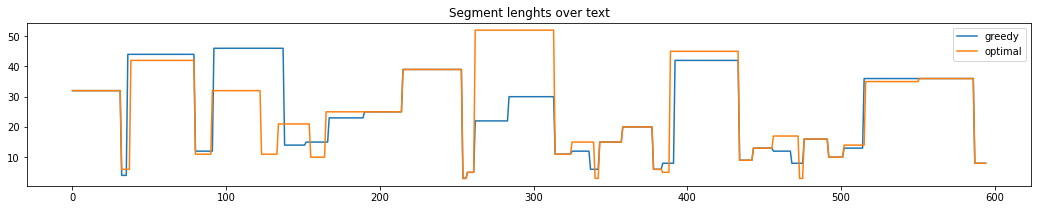

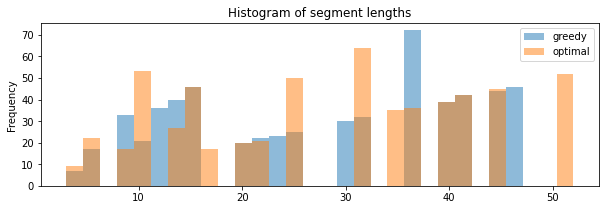

In [216]:
strs = " "
for i in range(len(del_sponsor_sentence)):
  if(del_sponsor_sentence[i] != " "):
    strs =del_sponsor_sentence[i]
  if(i+1<len(del_sponsor_sentence)):
    if(strs == del_sponsor_sentence[i+1]):
      del_sponsor_sentence[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(del_sponsor_sentence).dot(wrdvecs)
new_length = len(del_sponsor_sentence)**0.5
print(new_length)
penalty = get_penalty([sentence_vectors], new_length)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(del_sponsor_sentence, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(del_sponsor_sentence), len(segmented_text), len(del_sponsor_sentence) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(del_sponsor_sentence, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

In [217]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

['Hi friends. ', "Happy Wednesday or Thursday if you're watching over on YouTube. ", 'Hey, how are you doing? ', "I hope you're having a wonderful day so far. ", 'My name is Bailey. ', 'Sarian. ', 'And this is the dark History podcast on your team song for dark history. ', "Don't I anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that I never learned in school if you're new here. ", 'Hi, welcome, take a seat by me. ', "Don't be shy. ", "If you're interested in learning about people and events that your history books in a covering school and maybe should have then you'll fit in right in here with us. ", 'Ok luck today, story. ', "It's uncomfortable. ", "Okay, it's heartbreaking. ", "It's it's just, it's it's awful. ", "It's that there's, those are all the words I can think of it, just doesn't make any sense. ", "But with all of that being said, there's really like, no sugar-coating this, this is what happened and it's when we

In [218]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [219]:
headlines = headlineGenerator(podcast_test, min_length, max_length)

Ignoring args : (5, 150)


In [220]:
for headline in headlines:
  print(headline)
  

{'generated_text': 'Dark History Podcast - A Dark History Podcast'}
{'generated_text': 'Rosewood, Florida - A Story of a Hero'}
{'generated_text': 'The Rosewood Massacre'}
{'generated_text': 'Rosewood, Sumner, Sumner, Rosewood, Sumner, Sumner, Rose'}
{'generated_text': 'Are You Sure?'}
{'generated_text': 'Saint Nick, Fanny Story, Saint Nick, Saint Nick, Saint Nick, Saint Nick,'}
{'generated_text': 'The Black Man Attacks'}
{'generated_text': 'Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter'}
{'generated_text': 'Jesse Hunter, a Black Man, Attack Force Panty'}
{'generated_text': 'Sam Carter, The Posse Stop Process'}
{'generated_text': 'Hello Fresh - The Best Meal Kits For the Dark History Posse'}
{'generated_text': 'Rosewood Black Community - Is Jesse hiding in a Home?'}
{'generated_text': 'Sarah Carriers House'}
{'generated_text': 'The Posse and the White Mob'}
{'generated_text': 'The Black Community in Rosewood'}
{'generated_text': 'The White Man, But He Was Friendl

In [221]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['Dark History Podcast', '-', 'A Dark History Podcast']
['Dark History Podcast', '-', 'A Dark History Podcast']
<class 'str'>
['Rosewood', ',', 'Florida', '-', 'A Story of a Hero']
['Rosewood', ',', 'Florida', '-', 'A Story of a Hero']
<class 'str'>
['The Rosewood Massacre']
['The Rosewood Massacre']
<class 'str'>
['Rosewood', ',', 'Sumner', ',', 'Sumner', ',', 'Rosewood', ',', 'Sumner', ',', 'Sumner', ',', 'Rose']
['Rosewood', ',', 'Sumner', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'Rose']
<class 'str'>
['Are You Sure?']
['Are You Sure?']
<class 'str'>
['Saint Nick', ',', 'Fanny Story', ',', 'Saint Nick', ',', 'Saint Nick', ',', 'Saint Nick', ',', 'Saint Nick', ',', '']
['Saint Nick', ',', 'Fanny Story', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '']
<class 'str'>
['The Black Man Attacks']
['The Black Man Attacks']
<class 'str'>
['Jesse Hunter', ',', 'Jesse Hunter', ',', 'Jesse Hunter', ',', 'Jesse Hunter', ',', 'Jesse Hunter']
['Jesse Hunter', ',', ' ', ' ', ' ', ' ', ' ', ' ',

In [222]:
for headline_string in headlines_string:
  print(headline_string)

 Dark History Podcast - A Dark History Podcast
 Rosewood , Florida - A Story of a Hero
 The Rosewood Massacre
 Rosewood , Sumner Rose
 Are You Sure?
 Saint Nick , Fanny Story 
 The Black Man Attacks
 Jesse Hunter ,
 Jesse Hunter , a Black Man Attack Force Panty
 Sam Carter , The Posse Stop Process
 Hello Fresh - The Best Meal Kits For the Dark History Posse
 Rosewood Black Community - Is Jesse hiding in a Home?
 Sarah Carriers House
 The Posse and the White Mob
 The Black Community in Rosewood
 The White Man , But He Was Friendly to His Neighborhoods
 Rosewood Massacre - The Rosewood Massacre
 The KKK , The 'Klaus'
 The Mob Shot Mingo Williams
 What's a lot of names and Throwing at you?
 The Rosewood Train Station
 Squarespace - The Perfect Platform For Your Brand
 The Rosewood Massacre - The All White Jury
 The Little Things in Life Are Smiling At Your Neighbor
 Save Money With Stamps . com
 Rosewood , the survivors are living in constant fear
 The Black Community , Not Forgiving
 Ros

In [223]:
len(headlines_string)

32

In [227]:
print(headlines_string)
3

[' Dark History Podcast - A Dark History Podcast', ' Rosewood , Florida - A Story of a Hero', ' The Rosewood Massacre', ' Rosewood , Sumner Rose', ' Are You Sure?', ' Saint Nick , Fanny Story ', ' The Black Man Attacks', ' Jesse Hunter ,', ' Jesse Hunter , a Black Man Attack Force Panty', ' Sam Carter , The Posse Stop Process', ' Hello Fresh - The Best Meal Kits For the Dark History Posse', ' Rosewood Black Community - Is Jesse hiding in a Home?', ' Sarah Carriers House', ' The Posse and the White Mob', ' The Black Community in Rosewood', ' The White Man , But He Was Friendly to His Neighborhoods', ' Rosewood Massacre - The Rosewood Massacre', " The KKK , The 'Klaus'", ' The Mob Shot Mingo Williams', " What's a lot of names and Throwing at you?", ' The Rosewood Train Station', ' Squarespace - The Perfect Platform For Your Brand', ' The Rosewood Massacre - The All White Jury', ' The Little Things in Life Are Smiling At Your Neighbor', ' Save Money With Stamps . com', ' Rosewood , the su

3

In [225]:
first_sentence = []
for i in range(len(segmented_text)):
  first_sentence.append(segmented_text[i][0].strip().rstrip().rstrip('.').rstrip('?'))
  print(segmented_text[i][0])
  print(type(segmented_text[i][0]))
  print(len(segmented_text[i]))

Hi friends. 
<class 'str'>
32
For all of that, on the morning of January 1st, 1923 30 year old James, and his 22-year old wife, Fannie, Taylor woke up at a home, and a town called Sumner, a neighboring community of Rosewood. 
<class 'str'>
6
I know because it is. 
<class 'str'>
42
Now, it's a Rosewood. 
<class 'str'>
11
James at work. 
<class 'str'>
32
Sure again, because it's, it's a 1920s. 
<class 'str'>
11
 
<class 'str'>
21
Why, why would she lie, why would you lie? 
<class 'str'>
10
Zero evidence that Jesse was the perpetrator, but that doesn't matter to them. 
<class 'str'>
25
So they know exactly where Sam Carter lives and they had straight to his house. 
<class 'str'>
25
This is just the tip of the iceberg. 
<class 'str'>
39
So the black community is terrified by what they're seeing happening in their own town of Rosewood. 
<class 'str'>
3
Other than Sarah carriers house. 
<class 'str'>
5
She also lived in the house with her. 
<class 'str'>
52
So this was no longer about Fanny 

In [226]:
print(first_sentence)
print(len((first_sentence)))

['Hi friends', 'For all of that, on the morning of January 1st, 1923 30 year old James, and his 22-year old wife, Fannie, Taylor woke up at a home, and a town called Sumner, a neighboring community of Rosewood', 'I know because it is', "Now, it's a Rosewood", 'James at work', "Sure again, because it's, it's a 1920s", '', 'Why, why would she lie, why would you lie', "Zero evidence that Jesse was the perpetrator, but that doesn't matter to them", 'So they know exactly where Sam Carter lives and they had straight to his house', 'This is just the tip of the iceberg', "So the black community is terrified by what they're seeing happening in their own town of Rosewood", 'Other than Sarah carriers house', 'She also lived in the house with her', 'So this was no longer about Fanny or Jesse', 'He was a white man, but he was friendly to his neighbors', 'They were also white families in Sumner who sheltered and protected, people who is a new often people who works for them Friday morning on January